In [251]:
from numpy import * 
from matplotlib.pyplot import *

In [252]:
import os
import glob
import numpy as np

def read_tpetra_output(label, nx, ny, directory='.'):
    """
    Reads multiple Tpetra vector output files of the form 'label_<rank>.out'
    and returns a 2D NumPy array of shape (nx, ny).

    Parameters:
        label (str): The prefix label used in the file names (e.g., "rhs").
        nx (int): Number of grid points in x-direction.
        ny (int): Number of grid points in y-direction.
        directory (str): Directory where the files are located (default: current).

    Returns:
        np.ndarray: Assembled 2D array of shape (nx, ny).
    """
    data = np.zeros((nx, ny))

    # Find all matching files
    pattern = os.path.join(directory, f"{label}_*.out")
    files = glob.glob(pattern)

    if not files:
        raise FileNotFoundError(f"No files found with pattern: {pattern}")

    for filename in files:
        with open(filename, 'r') as f:
            for line in f:
                line = line.strip().strip('()')
                if not line:
                    continue
                i_str, j_str, val_str = line.split(',')
                i = int(i_str.strip())
                j = int(j_str.strip())
                value = float(val_str.strip())
                data[i, j] = value

    return data

In [253]:
import math
import numpy as np

PI = math.pi

def phi_exact(x, y):
    return -1*math.sin(PI * x) * math.sin(PI * y)

def calculate_n(x, y):
    return 1.0 + math.sin(2.0 * PI * x)**2 + y**2

def calculate_rho(x, y):
    term_inside_bracket_part1 = 2.0 * y * math.cos(PI * y)
    inner_expr_for_term2 = -1.0 - 2.0 * y**2 + \
                           4.0 * math.cos(2.0 * PI * x) + \
                           3.0 * math.cos(4.0 * PI * x)
    term_inside_bracket_part2 = PI * inner_expr_for_term2 * math.sin(PI * y)
    return PI * math.sin(PI * x) * (term_inside_bracket_part1 + term_inside_bracket_part2)

In [254]:
def plot_comparison(numerical_data, analytical_func, x_coords, y_coords, X_grid, Y_grid, title_prefix="Value"):
    fig, ax = subplots(1, 3, figsize=(18, 6))

    analytical_data_evaluated = vectorize(analytical_func)(X_grid, Y_grid)

    im0 = ax[0].pcolor(x_coords, y_coords, numerical_data.T, shading='auto')
    ax[0].set_title(f'Numerical {title_prefix} (Tpetra Output)')
    colorbar(im0, ax=ax[0], label=f'{title_prefix} value')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')

    im1 = ax[1].pcolor(x_coords, y_coords, analytical_data_evaluated, shading='auto')
    ax[1].set_title(f'Analytical {title_prefix}')
    colorbar(im1, ax=ax[1], label=f'{title_prefix} value')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')

    im2 = ax[2].pcolor(x_coords, y_coords, analytical_data_evaluated - numerical_data.T, shading='auto')
    ax[2].set_title(f'Difference (Analytical - Numerical {title_prefix})')
    colorbar(im2, ax=ax[2], label=f'Difference in {title_prefix}')
    ax[2].set_xlabel('x')
    ax[2].set_ylabel('y')

    tight_layout()
    show()


This system involves solving a **generalized Poisson equation** in two dimensions, which is a fundamental partial differential equation (PDE) used in various fields like physics, engineering, and computational fluid dynamics.

The equation being solved is:

$$
\nabla \cdot (n(x,y) \nabla \phi(x,y)) = \rho(x,y)
$$

Here's what each term represents:

* $ \phi(x,y) $: This is the unknown scalar field we are trying to find (e.g., electric potential, temperature, pressure).

* $ n(x,y) $: This is a **spatially varying coefficient**. It represents a material property or a diffusion coefficient that changes across the domain. Its presence makes the equation more complex than the standard Poisson equation.

* $ \rho(x,y) $: This is the **source term**, representing sources or sinks within the domain.

* $ \nabla $: This is the del operator (nabla), representing spatial derivatives.

  * $ \nabla \phi $: The gradient of $ \phi $, which is a vector field indicating the direction and rate of the greatest increase of $ \phi $.

  * $ \nabla \cdot (\cdot) $: The divergence operator, which measures the magnitude of a source or sink of a vector field at a given point.

For testing the numerical solution, we use a **method of manufactured solutions**. This involves picking a known analytical solution for $ \phi(x,y) $ and a spatially varying $ n(x,y) $, and then mathematically deriving the corresponding source term $ \rho(x,y) $ that would make the equation hold true. This allows for direct comparison between the numerical result and the exact solution.

The specific analytical functions used as a test case are:

* **Exact Solution for $ \phi(x,y) $:**

$$\phi(x,y) = \sin(\pi x) \sin(\pi y)$$

* **Spatially Varying Coefficient $ n(x,y) $:**

$$n(x,y) = 1 + \sin^2(2\pi x) + y^2$$

* **Derived Source Term $ \rho(x,y) $:**

$$\rho(x,y) = \pi \sin(\pi x) \left(2y \cos(\pi y) + \pi (-1 - 2y^2 + 4 \cos(2\pi x) + 3 \cos(4\pi x)) \sin(\pi y)\right)$$

This choice of $ \phi(x,y) $ naturally satisfies **homogeneous Dirichlet boundary conditions** ($ \phi = 0 $) on the boundaries of a unit square domain ($[0,1] \times [0,1]$). This simplifies the setup as no explicit boundary values need to be specified for $ \phi $ on the domain edges; they are implicitly zero.

In [255]:
nx = 1000
ny = nx
x= np.linspace(0, 1, nx, endpoint=True)
y = np.linspace(0, 1, ny , endpoint=True)
X, Y = np.meshgrid(x, y)

nmpi = 4
generalized = True

In [256]:
import subprocess

os.system("rm -f *.out")

command = ["mpirun", "-n", str(nmpi), "../build/Poisson", "--nx=%s"%str(nx), "--ny=%s"%str(ny)]
if generalized:
    command.append("--generalized")

try:
    result = subprocess.run(command, check=True, capture_output=True, text=True)
    print("Command executed successfully:")
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print(f"Error executing command: {e}")
    print(f"Stderr: {e.stderr}")

Command executed successfully:
Clearing old data (if any)

Level 0
Setup Smoother (MueLu::Ifpack2Smoother{type = CHEBYSHEV})
chebyshev: ratio eigenvalue (computed) = 20
chebyshev: max eigenvalue (calculated by Ifpack2) = 1.89637
"Ifpack2::Chebyshev": {Initialized: true, Computed: true, "Ifpack2::Details::Chebyshev":{degree: 2, lambdaMax: 1.89637, alpha: 20, lambdaMin: 0.0948187, boost factor: 1.1, algorithm: first}, Global matrix dimensions: [1000000, 1000000], Global nnz: 4984016}

Level 1
Prolongator smoothing (MueLu::SaPFactory)
Matrix filtering (MueLu::FilteredAFactory)
Build (MueLu::CoalesceDropFactory)
Build (MueLu::AmalgamationFactory)
lightweight wrap = 1
algorithm = "classical" classical algorithm = "default": threshold = 0, blocksize = 1
Detected 3996 Dirichlet nodes
Number of dropped entries in unamalgamated matrix graph: 0/4984016 (0%)
Filtered matrix is not being constructed as no filtering is being done
Build (MueLu::TentativePFactory)
Build (MueLu::UncoupledAggregationFa

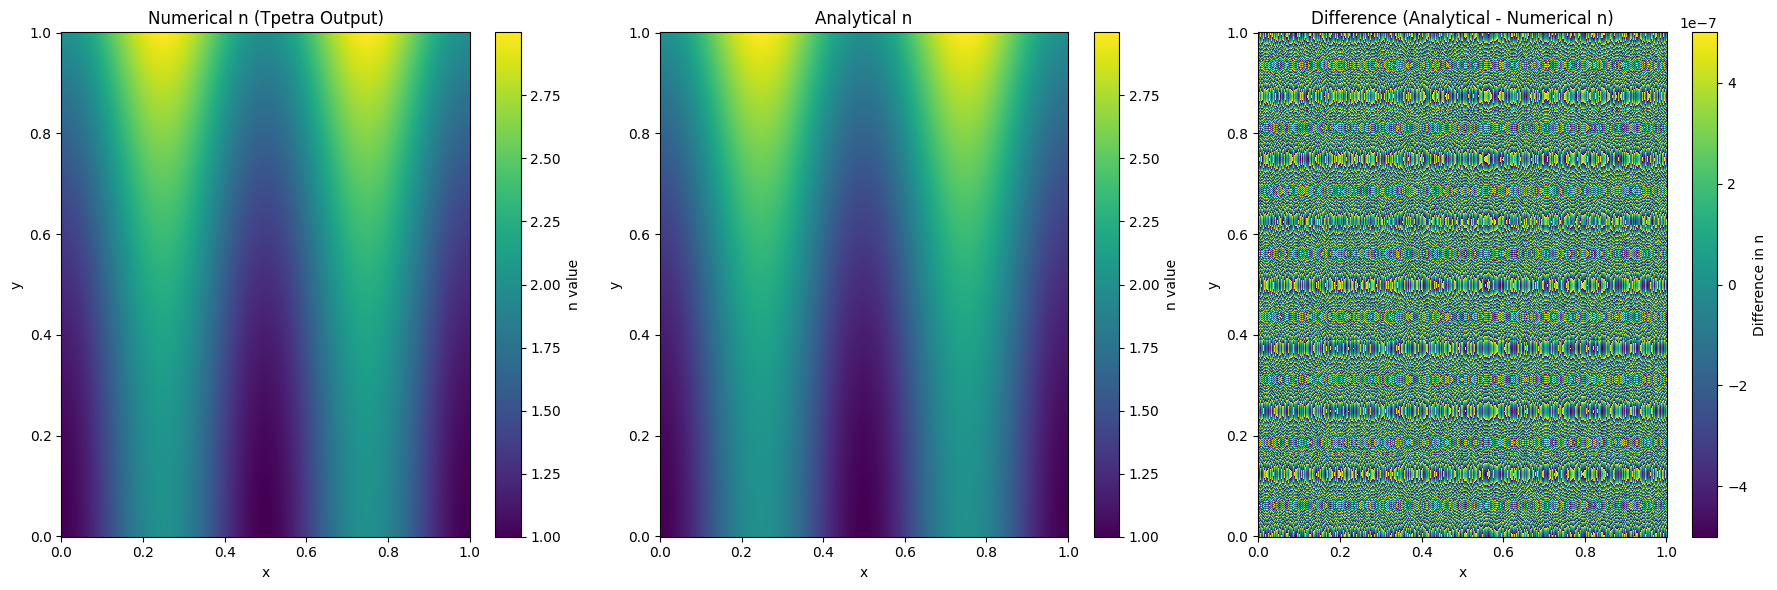

In [257]:
if generalized:
    n_data = read_tpetra_output("n", nx=nx, ny=nx)

    plot_comparison(n_data, calculate_n, x, y, X, Y, title_prefix="n")



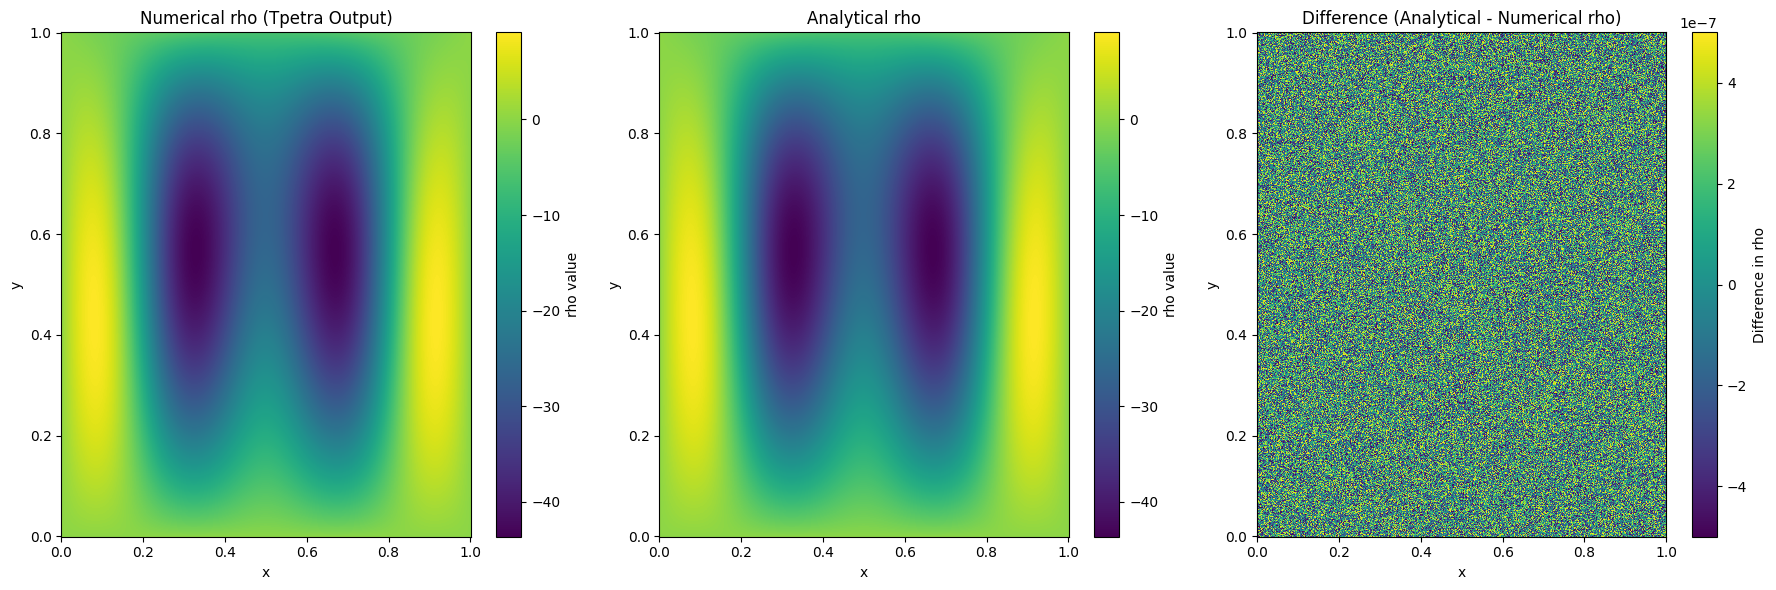

In [258]:
data = read_tpetra_output("rhs", nx=nx, ny=nx)

plot_comparison(data, calculate_rho, x, y, X, Y, title_prefix="rho")


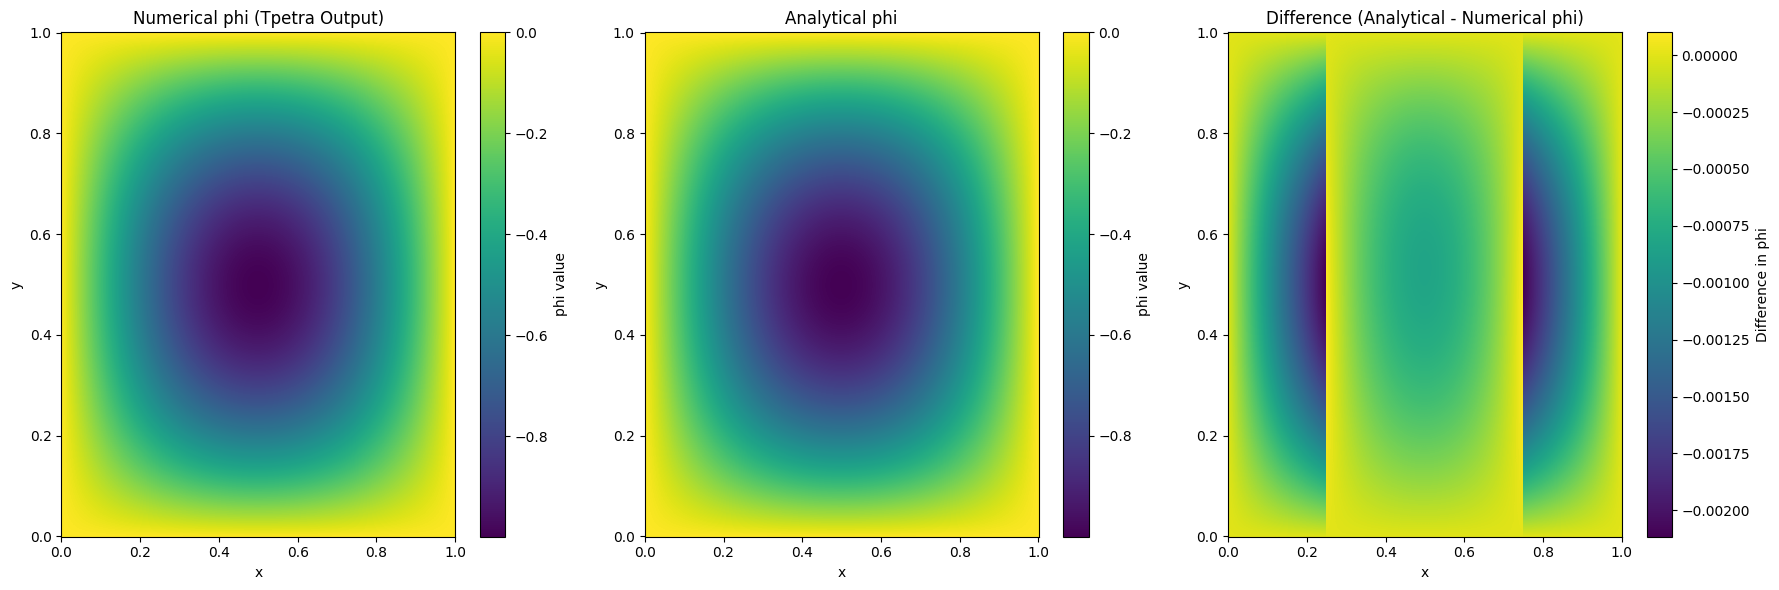

In [259]:
data = read_tpetra_output("phi", nx=nx, ny=nx)

plot_comparison(data/nx/ny, phi_exact, x, y, X, Y, title_prefix="phi")
